# **Libraries installation**

In [1]:
!pip install torchsummary
!pip install torchmetrics
!pip install torchvision
!pip install opencv-python
!pip install fxpmath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 19.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 16.7 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 13.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.18.1
    Uninstalling nvidia-nccl-cu12-2.18.1:
      Successfully uninstalled nvidia-nccl-cu12-2.18.1
  Atte

# **Simulated Annealing**

The *Simulated Annealing* algorithm comes from the world of metallurgy, where when melting a metal you have to let it cool slowly to get a good result. Therefore, this was translated to the world of algorithms in which, in order to find the optimal solution to a problem where the sample space is large and unknown, it gives very good results.

## **Algorithm**

Imagining the following image as the sample space we want to optimise, in this case, looking for the maximum of the function. It is sometimes very difficult to find the global maximum (***GM, global maximum***) as we could get stuck at a local maximum.

 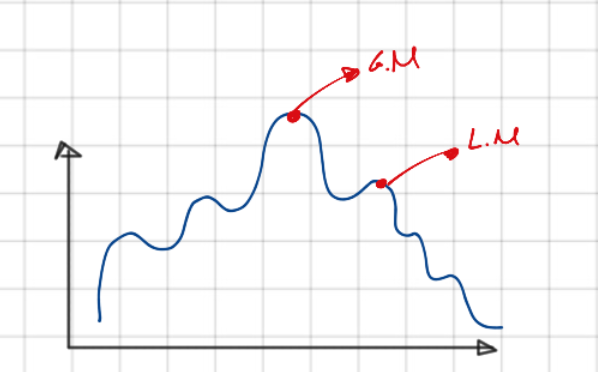

Therefore, initially the algorithm searches for a randomly chosen initial state and sets a maximum and minimum temperature value for the model.

Once the algorithm is started:
* 1- the cost of the model in the current state is evaluated, where the cost is a function chosen to evaluate the state.
* 2- the next neighbour is calculated, i.e. the next possible state. The search for this new state is calculated in different ways depending on the problem to be solved, but in all cases, this neighbour search calculation depends directly on the temperature of the model at that moment. At higher temperatures, the search for this neighbour is more random, i.e. it may be further away, but as the temperature cools (as in the metallurgy problem) this neighbour is increasingly closer to the previous state, thus converging the problem.
* 3- Once this neighbour has been obtained, the cost of being in this new state is calculated.
* 4- With the cost of the new neighbour and the previous one, the difference is calculated, and if the new cost is better, lower, than the previous one, this new state is accepted. But if it is not a better solution, this new state is only accepted if the following condition  $e^{(\Delta E/T)}>rand(0,1)$.

  Therefore, in the case that we are in a worse case, this will be accepted only in the case that the previous condition is fulfilled. That is, at the moment when this expression is greater than the random value of $rand(0,,1)$,  which is more easily fulfilled at the beginning of the algorithm at the moment when $\Delta E<0$ and $T$, temperatureis very high, resulting in a value of  $e^{(\Delta E/T)}$ very close to 1, so there is a high probability that it is greater than the random value of rand(0,1) and this nine state is accepted, even if it is worse, but this can prevent us from stalling at a local maximum. While on the other hand, in the case that  $\Delta E<0$ and the $T$ is low, close to 0, and it is more complicated to accept this new state.
e nuevo estado.

## **Quantization Optimisation Algorithm**

In our case, we aim to optimise the size of the model by quantizing the fractional part of the weights and activations of the model. 

Often, in Machine Learning models, we have a precision of 32 bits because of the type of design that the libraries have, but sometimes it is unnecessary to have so much precision in the weights and biases of the model. In some layers, with lower accuracies we can get the same model metrics or we can even accept to have a slightly worse model but in order to have a much smaller model in terms of storage issues.
For certain operations the final result is the same, or slightly lower, but with this we manage to reduce the size of the model significantly. With this we can obtain lightweight models that are manageable for devices with limited resources. In our case, it allows us to implement these models in FPGAs.

In our case, the algorithm used follows the same as explained above, but the cost function is the following: 
$$cost=\gamma*((lower bound-mAP50)**2) + \beta*avg bits -\alpha*lower bound + \Omega*total_{loss}$$
Where the values of $\gamma(=1)$, $\alpha(=0.5)$, $\beta(=50)$ can be specified, in brackets, the default values are specified for the time being. 

In the code that we find in ***simulated_annealing.py*** there are a series of parameters that we can modify, which have to be done directly from there. Where we can see the parameters:
* simulations = 1 -> this parameter allows us to perform several simulations of the algorithm several times which allows us to analyse possible convergences of the model. With several simulations it allows us to extract metrics such as variance and mean as a result of the optimisation of the quantization of the weights and activations.
* Max_steps = 100 -> the number of epochs of the convergence algorithm. No matter how many epochs we set, the algorithm always converges to a solution.
* interval = (4, 18,) -> interval of the values in which we want our model to search for the different quantization levels for each layer in a random way.
* max_degradation = 5 -> the maximum degradation we are willing to accept from the model, from the cost metric.
* alpha = 0 -> Cost function parameter 
* beta = 20 -> Parameter of the cost function
* gamma = 100 -> Cost function parameter
* n_slices = 5 -> Here you specify in the number of blocks you want to divide the model, in order to apply the algorithm in each one. The bigget n_slices the better convergence of the algorithm but the computational cost will be higher.
 
This selection of constants may vary depending on the problem and the importance we want to give to these penalties.

Independientemente de esta configuración, también dependemos del fichero de ***config.py*** para la seleccción del modelo.

En la subcarpeta del modelo ***model_opt*** se encuentran las diferentes pruebas realizadas, y el modelo de optimización obtenido con dicha precisión, por si luego se quuieren hacer pruebas de ruido y de predicciones.

**simulated_annealing.py** dividimos el pipeline de la arquitectura en N y se realiza el proceso del simmulated annealing en cada uno de los N trozos.

Se observa que para un límite de rango de bits con un limite inferior, converge mejor a una solución óptima, cuanto más slices hay.

In [ ]:
!python quantization/simulated_annealing.py

##############################################################
              Simulation 1 of 5         
##############################################################
=> Loading checkpoint
Model loaded: tinyissimoYOLO/NAdam_None_Airbus_256_BATCH_32_LR_0.0005/model/19_YOLO_best.pth.tar
=> Loading checkpoint
Model loaded: tinyissimoYOLO/NAdam_None_Airbus_256_BATCH_32_LR_0.0005/model/19_YOLO_best.pth.tar
Eval: Annealing: : 100%|████████████████████████| 92/92 [00:03<00:00, 27.45it/s]
---------------------------------------------------
-------------Loss Summary eval {mode}--------------
Total Loss  |Loss Coord  |Conf Loss   |No Obj Loss |Class Loss  |
13.225      |6.324       |4.869       |1.947       |0.086       |
---------------------------------------------------
Initial mAP50: 0.718, Initial avg bits: 32.000, Initial size: 3.445 MB
Initial fractional part: [26, 24, 26, 26, 24, 26, 25, 24, 27, 25, 23, 30, 27, 24, 26, 26, 22, 28, 26, 23, 24, 26, 22, 25, 24, 22, 26, 24, 22, 28, 25, 28, 2

# Analysing the inference time of the best optimised model

For the case of Tinyissimo YOLO, the best performance of mAP during training has been obtained. And for the case of 5 slices, 0% degradation and the interval (4,10) the best convergence of the simulated annealing algorithm is observed. Therefore, here we intend to analyse the mAP@50 on the test data.

The model selected in the path must be consistent with the configuration file.

Here we are testing how it predict with the tiles

In [ ]:
from predict.test_tiles import test_prediction
path_opt_model = '5_sims_max_steps_100_slices_5_interval_4_10_degredation_0/sim_4'
boolean_optim = True
# test_prediction(tile_size = 256, overlap = 0.2, threshold=0.4, iou_threshold=0.4)
# test_prediction(tile_size = 256, overlap = 0.2, threshold=0.4, iou_threshold=0.4)
test_prediction(tile_size = 256, overlap = 0.1, threshold=0.4, iou_threshold=0.3)
# test_prediction(tile_size = 256, overlap = 0.0, threshold=0.4, iou_threshold=0.4)
# test_prediction(tile_size = 350, overlap = 0.2, threshold=0.4, iou_threshold=0.4)
# test_prediction(tile_size = 512, overlap = 0.2, threshold=0.4, iou_threshold=0.4)

# **Predict**

Here we can predict with the videos

In [ ]:
from predict import process_media
import os

folder_test = 'Datasets/test'
files_to_test = os.listdir(folder_test)
# files_to_test = ['90c365f8-18b6-4230-be74-cd856a1ba98f.jpg']
path_opt_model = '1_sims_max_steps_100_slices_3_interval_4_10_degredation_5/sim_1'
boolean_optim = True
process_media(folder_test, files_to_test)